In [1]:
import pdb,sys,os
import warnings
warnings.filterwarnings('ignore')
import anndata
import scanpy as sc
sc.settings.verbosity = 0
import argparse
import copy
import numpy as np
import scipy
import timeit

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from typing import Tuple


In [2]:
import scSemiProfiler as semi
from scSemiProfiler.utils import *

# Example
We provide an example dataset containing 12 samples from COVID-19 patients with 6 different severity levels. We will go through the process of using scSemiProfiler to semi-profile this example cohort. Then we will evaluate the semi-profiling performance by comparing the downstream anlaysis results using the semi-profiled cohort and the real-profiled cohort. We will show that even with only 2 representatives, we can accurately reproduce single-cell level downstream analysis results. Particularly, samples of different COVID-19 severity level can also be accurately inferred. The detailed documentation about all the funtions can be found in the API documentation section.

## Step 1 Initial Setup 
In this step, the user provided bulk data is preprocessed, dimensionality reduced, and clustered. 
The sample closest to the cluster centroids are selected as initial representatives.

The bulk data should be provided as an h5ad file and can either be provided as raw count, normalized count, or log-transformed format. Sample IDs should be stored in adata.obs['sample_ids'] and gene names should be stored in adata.var.index.

### Recommended data format (same as example)
single-cell data: Preprocess the data using Scanpy's pipeline (quality control, normalization, feature selection). Then convert the data back to count scale using expm1.
bulk data: Use normalized count 
Then use the same parameters as the example.

*Estimated Time: Less than 1 minute*

In [3]:
# uncomment to see function documentations
# can also be found in the API documentation section
# print(semi.initsetup.__doc__)

In [3]:
name = 'run_example_data'
bulk = 'example_data/bulkdata.h5ad'
logged = False
normed = True
geneselection = False
batch = 2

In [4]:
semi.initsetup(name,bulk,logged=logged,normed=normed,geneselection=geneselection,batch=batch)

Start initial setup
Initial setup finished. Among 12 total samples, selected 2 representatives:
BGCV09_CV0279
MH9143426


We set the representative batch size to be 2. Given the total sample size to be 12, We can estimate the cost using the 'estimate_cost' function.

In [5]:
# print(estimate_cost.__doc__)

In [6]:
_ = estimate_cost(12,2)


Estimated semi-profiling cost: $11320.0
Estimated cost if conducting real single-cell profiling: $18000.0
Percentage saved: 37.1%


This is the end of the initial setup step. Bulk data is preprocessed and analyzed. Relevant information is stored in the project name folder for subsequent analysis.

## Step 1.5 Acquiring Single-cell Data for Representatives
After running the initial setup step, we know the selected representatives for performing real single-cell experiments. The representative sample IDs are printed on the screen when running the 'semi.initsetup' function, and also stored in the 'project_name/status/init_representatives.txt' file.

The user will sequence the representatives to obtain their actual single-cell data accordingly. In our example, we offer a function that allows for the extraction of representatives' single-cell data from a pre-prepared dataset. This function will automatically detect the latest representatives and acquire single-cell data.

*Estimated Time: Less than 1 minute*

In [7]:
# print(semi.get_eg_representatives.__doc__)

In [8]:
# use function get_cohort_sc instead if running preprocessed cohort datasets 
# e.g. the entire COVID-19 dataset
# print(get_cohort_sc.__doc__)
semi.get_eg_representatives(name)

Obtained single-cell data for representatives.


## Step 2 Single-cell Processing & Feature Augmentation
In this step, we preprocess the representatives' single-cell data and apply various feature augmentations.These enhancements include the addition of gene set scores, aggregation of neighbor cell information, and calculation of gene importance weights.\
*Estimated Time: 2 minutes for each sample with 7000 cells*

In [9]:
#print(semi.scprocess.__doc__)

In [10]:
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed=True,logged=False,cellfilter=False,threshold=1e-3,geneset=True,weight=0.5,k=15)

Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


## Step 3 Single-cell Inference
In this step, we employ a VAE-GAN-based deep generative model to infer the single-cell data for each target (non-representative) sample.\
The model training is divided into three distinct stages:

1. **Pretrain 1**: The model is trained to reconstruct the representatives' single-cell data.

2. **Pretrain 2**: The model continues its reconstruction training in full batch mode, now incorporating an additional "representative bulk loss" term in the loss function. This term ensures that the reconstructed cells' average expression is similar to pseudobulk.

3. **Inference**: The bulk data difference between the representative and target sample is integrated into the generator's reconstruction process through a 'target bulk loss'. This guides the generator to accurately infer the target sample's cells.


*Estimated Time for Samples with Approximately 7000 Cells*:
   - Pretrain 1: 15 minutes per sample
   - Pretrain 2: 5 minutes per sample
   - Inference: 30 minutes per sample

### 3.1 Single target sample inference
Since performing inference for all non-representative samples could take a long time, we can first use 'semi.tgtinfer' function to infer one sample at a time and check if the training is successful.

In [4]:
## check dataset status

sids = []
f = open(name + '/sids.txt','r')
lines = f.readlines()
for l in lines:
    sids.append(l.strip())
f.close()

repres = []
f=open(name + '/status/init_representatives.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    repres.append(int(l.strip()))

cl = []
f=open(name + '/status/init_cluster_labels.txt','r')
lines = f.readlines()
f.close()
for l in lines:
    cl.append(int(l.strip()))
    
print('representatives:',repres)
print('cluster labels:',cl)

representatives: [6, 10]
cluster labels: [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


### Note
The i-th representative (0-based index) corresponds to the representative sample of the i-th cluster. The j-th element in the cluster label list indicates the cluster assignment of the j-th sample. For example, the sample with index 2 has cluster label 0 and the representative for cluster 0 is sample with index 6.

In [9]:
#print(semi.tgtinfer.__doc__)

In [5]:
bulktype = 'pseudobulk'

In [ ]:
semi.tgtinfer(name = name, representative = 6, target = 1, bulktype=bulktype)

### 3.2 Inference sanity check
After the inference is finished, we first perform some basic visualization to see if the model training was successful.

**Reconstruction**

Firstly, successful pretrain should generate near perfect reconstruction. We compare the representative's reconstructed cells with the original ones.

In [14]:
#print(visualize_recon.__doc__)

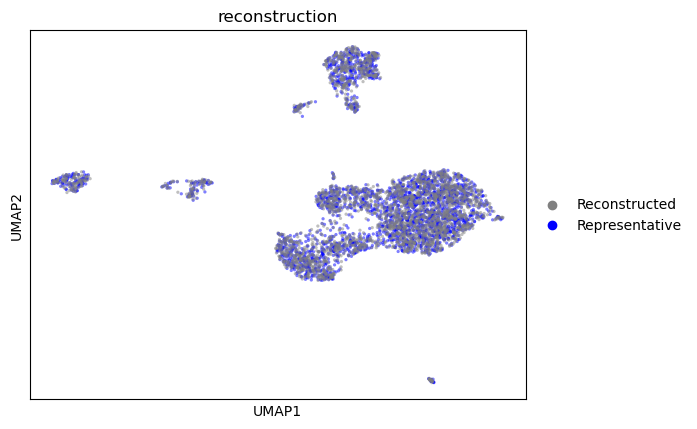

In [15]:
visualize_recon(name, 6)

The overlap indicates the reconstructed cells and representative cells are similar.

**Inference performance check**

Then, for any target sample, successful inference should generate target cells closer to the target ground truth than to the representative cells.

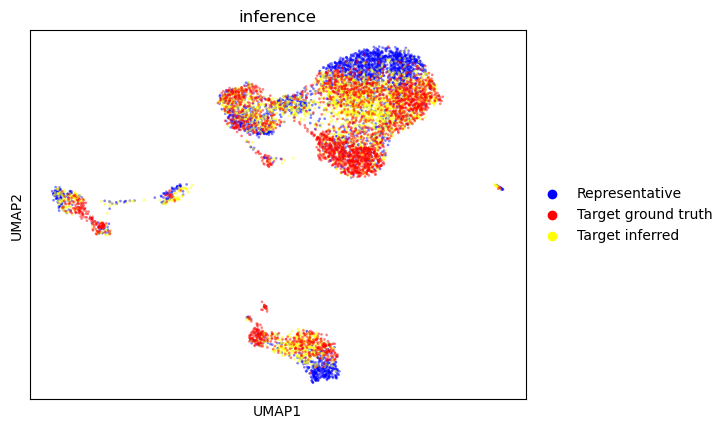

In [16]:
#print(visualize_inferred.__doc__)
visualize_inferred(name=name, target=1,  representatives=repres, cluster_labels = cl)

The overlap between the target inferred cells and target ground truth indicates good inference performance.

**Check training loss curve**

visualizing the loss curve during training:

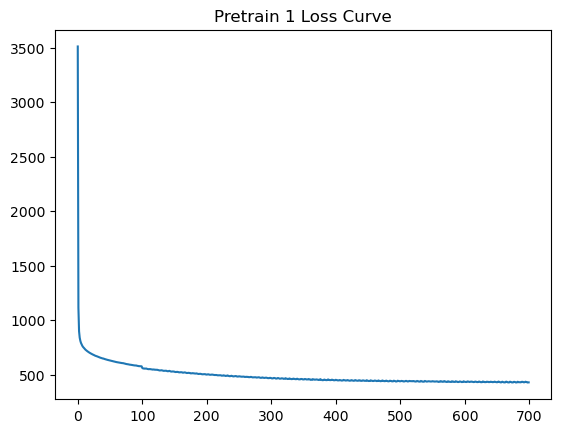

In [17]:
# PRETRAIN 1
# select a representative and check pretrain 1 loss curve
#print(loss_curve.__doc__)
loss_curve(name, reprepid=sids[6],tgtpid=None,stage=1) # or loss_curve(name, sids, reprepid=6,tgtpid=None,stage=1)

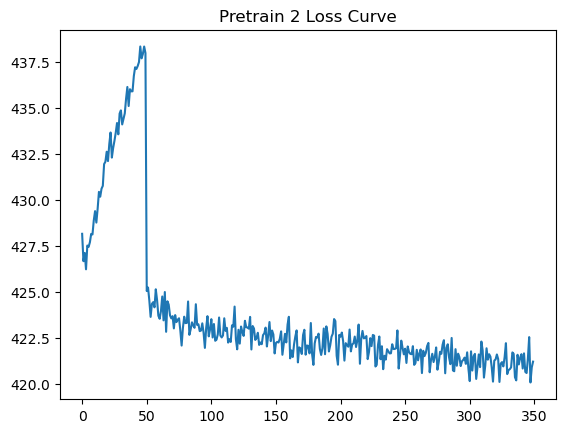

In [18]:
# PRETRAIN 2
loss_curve(name, reprepid=sids[6],tgtpid=None,stage=2) 

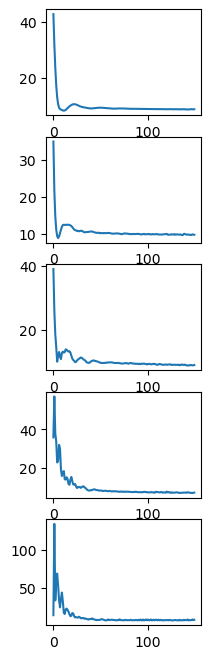

In [19]:
# INFERENCE
# target bulk loss during 5 ministages for inference
loss_curve(name, reprepid=6,tgtpid=1,stage=3)

### 3.3 Inference for the entire cohort
Once the sanity check is done, we can inferred the rest target samples. The 'semi.scinfer' function automatically detects which non-represenatatives have not been inferred and perform single-cell inference for them.

In [20]:
#print(semi.scinfer.__doc__)

In [4]:
representatives = name + '/status/init_representatives.txt'
cluster = name + '/status/init_cluster_labels.txt'

bulktype = 'pseudobulk'
semi.scinfer(name, representatives,cluster,bulktype)

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279


CUDA backend failed to initialize: Found CUDA version 11030, but JAX was built against version 11080, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


load existing pretrain 1 reconstruction model for MH9143426
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
load existing model
load existing pretrain 2 model for MH9143426
inference
Inference for AP8 has been finished previously. Skip.
Inference for BGCV02_CV0068 has been finished previously. Skip.
Inference for BGCV03_CV0084 has been finished previously. Skip.
Inference for BGCV03_CV0176 has been finished previously. Skip.
Inference for BGCV04_CV0164 has been finished previously. Skip.
Inference for BGCV07_CV0137 has been finished previously. Skip.
Inference for MH8919226 has been finished previously. Skip.
Inference for MH8919227 has been finished previously. Skip.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:28<00:00,  1.39s/it, v_num=1, train_loss_step=58


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:35<00:00,  1.43s/it, v_num=1, train_loss_step=58


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:17<00:00,  1.32s/it, v_num=1, train_loss_step=60


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:05<00:00,  1.24s/it, v_num=1, train_loss_step=64


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:04<00:00,  1.23s/it, v_num=1, train_loss_step=65


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:07<00:00,  1.25s/it, v_num=1, train_loss_step=57


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:01<00:00,  1.21s/it, v_num=1, train_loss_step=58


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [02:58<00:00,  1.19s/it, v_num=1, train_loss_step=59


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [02:59<00:00,  1.20s/it, v_num=1, train_loss_step=60


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [03:27<00:00,  1.38s/it, v_num=1, train_loss_step=61
Finished single-cell inference


## Comprehensive evaluation using downstream tasks
We can assemble the representatives' single-cell data and all inferred single-cell data into a semi-profiled cohort and use it to do all kinds of single-cell analysis. We compare the analysis results generated using the real-profiled cohort and semi-profiled cohort to evaluate the performance of semi-profiling.

### Assemble semi-profiled cohort
(training an MLP to annotate the cell types takes around 5 minutes)

In [ ]:
#print(assemble_cohort.__doc__)

In [7]:
representatives = repres
cluster_labels = cl
semisdata = assemble_cohort(name,
                representatives,
                cluster_labels,
                celltype_key = 'celltypes',
                sample_info_keys = ['states_collection_sum'])


Start assembling semi-profiled cohort.
Training cell type annotator.
Finished. Cost 274.5069406670518 seconds.
Generating semi-profiled cohort data.
Finished assembling semi-profiled cohort. Output as semidata.h5ad


### Read the real-profiled single-cell data to compare

In [8]:
gtdata = anndata.read_h5ad('example_data/scdata.h5ad')

### Compare the UMAP visualization
(The dimensionality reduction and neighbor graph calculation could be slow, taking around 5 minutes)

In [ ]:
#print(compare_umaps.__doc__)

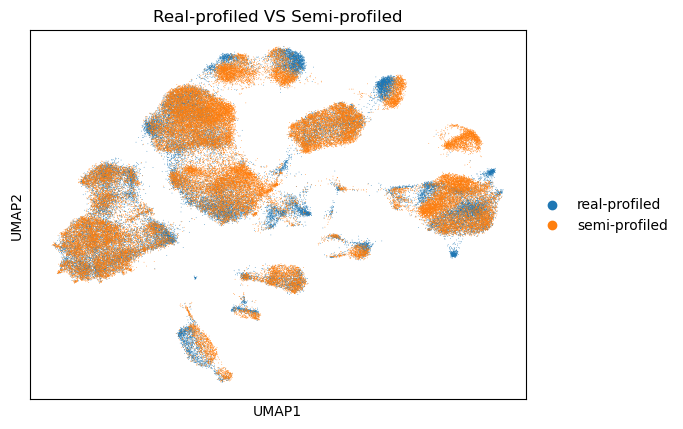

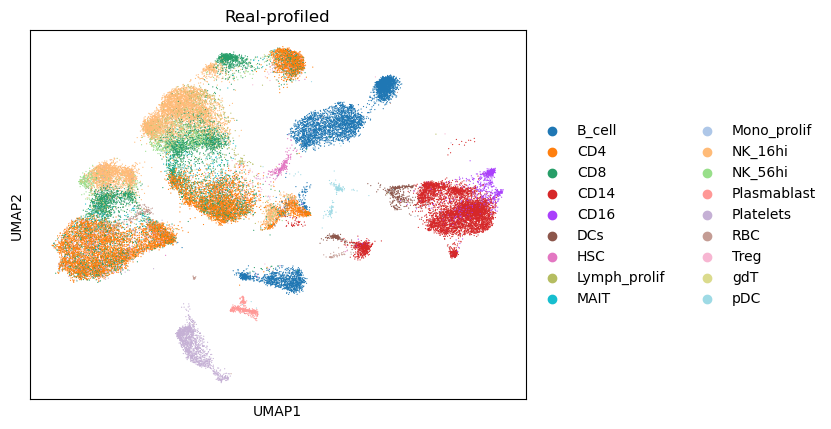

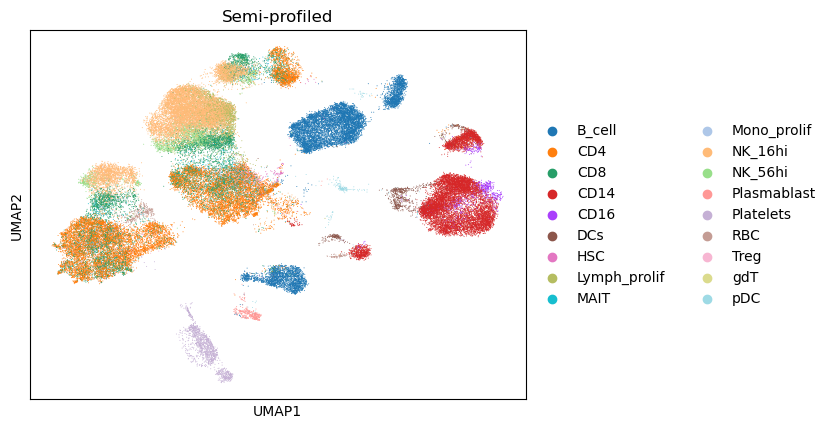

In [9]:
st= timeit.default_timer()
combined_data,gtdata,semidata = compare_umaps(
            semidata = semisdata,
            name = name,
            representatives = name + '/status/init_representatives.txt',
            cluster_labels = name + '/status/init_cluster_labels.txt',
            celltype_key = 'celltypes'
            )

### Compare cell type composition

In [ ]:
#print(celltype_proportion.__doc__)

In [10]:
totaltypes = np.array(semisdata.obs['celltypes'].cat.categories)

gtprop = celltype_proportion(gtdata,totaltypes)
semiprop = celltype_proportion(semisdata,totaltypes)


print('Pearson Correlation between the two versions of cell type proportions:')
print(scipy.stats.pearsonr(gtprop,semiprop))

Pearson Correlation between the two versions of cell type proportions:
PearsonRResult(statistic=0.9796796226302873, pvalue=1.3715822358756305e-12)


In [ ]:
#print(composition_by_group.__doc__)#

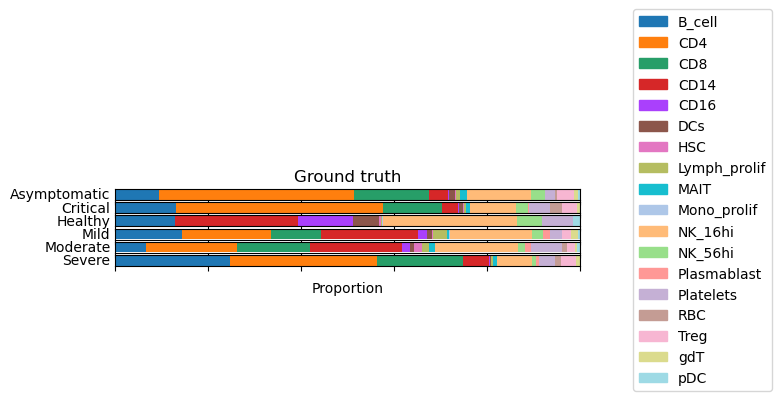

In [11]:
groupby = 'states_collection_sum'
composition_by_group(
    adata = gtdata,
    groupby = groupby,
    title = 'Ground truth'
    )


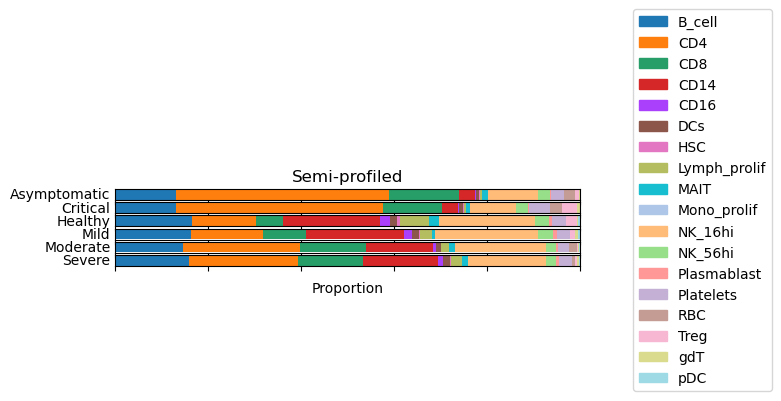

In [12]:
groupby = 'states_collection_sum'
composition_by_group(
    adata = semisdata,
    groupby = groupby,
    title = 'Semi-profiled'
    )

### Compare gene set activation pattern
We use the interferon pathway used in the COVID-19 study as an example.

In [13]:
# adapted from the COVID-19 study's GitHub repository https://www.nature.com/articles/s41591-021-01329-2
# https://www.gsea-msigdb.org/gsea/msigdb/cards/GO_RESPONSE_TO_TYPE_I_INTERFERON
IFN_genes = ["ABCE1", "ADAR", "BST2", "CACTIN", "CDC37", "CNOT7", "DCST1", "EGR1", "FADD", "GBP2", 	"HLA-A", 	"HLA-B", 	"HLA-C", 	"HLA-E", 	"HLA-F", 	"HLA-G", 	"HLA-H", 	"HSP90AB1", 	"IFI27", 	"IFI35", 	"IFI6", 	"IFIT1", 	"IFIT2", 	"IFIT3", 	"IFITM1", 	"IFITM2", 	"IFITM3", 	"IFNA1", 	"IFNA10", 	"IFNA13", 	"IFNA14", 	"IFNA16", 	"IFNA17", 	"IFNA2", 	"IFNA21", 	"IFNA4", 	"IFNA5", 	"IFNA6", 	"IFNA7", 	"IFNA8", 	"IFNAR1", 	"IFNAR2", 	"IFNB1", 	"IKBKE", 	"IP6K2", 	"IRAK1", 	"IRF1", 	"IRF2", 	"IRF3", 	"IRF4", 	"IRF5", 	"IRF6", 	"IRF7", 	"IRF8", 	"IRF9", 	"ISG15", 	"ISG20", 	"JAK1", 	"LSM14A", 	"MAVS", 	"METTL3", 	"MIR21", 	"MMP12", 	"MUL1", 	"MX1", 	"MX2", 	"MYD88", 	"NLRC5", 	"OAS1", 	"OAS2", 	"OAS3", 	"OASL", 	"PSMB8", 	"PTPN1", 	"PTPN11", 	"PTPN2", 	"PTPN6", 	"RNASEL", 	"RSAD2", 	"SAMHD1", 	"SETD2", 	"SHFL", 	"SHMT2", 	"SP100", 	"STAT1", 	"STAT2", 	"TBK1", 	"TREX1", 	"TRIM56", 	"TRIM6", 	"TTLL12", 	"TYK2", 	"UBE2K", 	"USP18", 	"WNT5A", "XAF1", "YTHDF2", "YTHDF3", "ZBP1"]

In [ ]:
#print(geneset_pattern.__doc__)

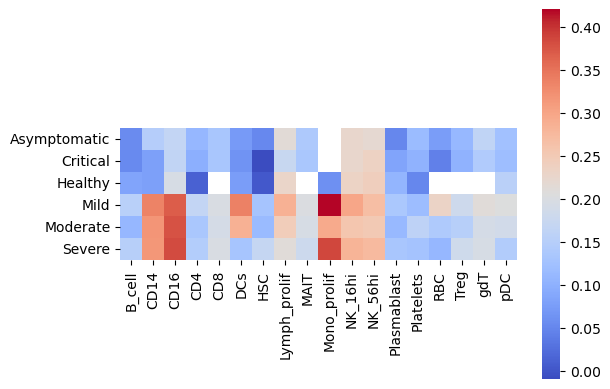

In [14]:
gtmtx = geneset_pattern(gtdata,IFN_genes,'states_collection_sum','celltypes')

In [15]:
# check if the data is logged
if semisdata.X.max() > 20:
    sc.pp.log1p(semisdata)

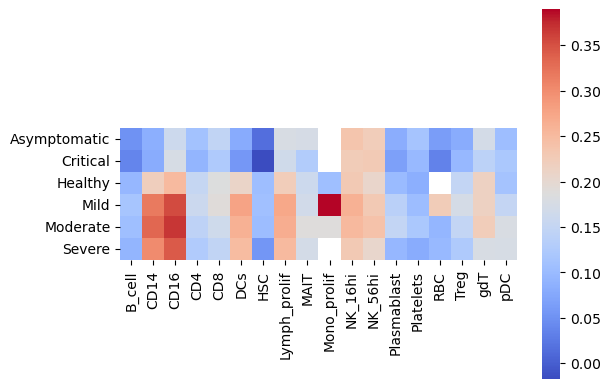

In [16]:
semismtx = geneset_pattern(semisdata,IFN_genes,'states_collection_sum','celltypes')

In [17]:
print('Correlation between the two heatmaps:')
scipy.stats.pearsonr(np.nan_to_num(gtmtx.flatten(),0),np.nan_to_num(semismtx.flatten(),0))

Correlation between the two heatmaps:


PearsonRResult(statistic=0.7505474606642433, pvalue=8.677544395178166e-21)

Based on only 2 representatives, the semi-profiled data reproduces the pattern for all COVID-19 severity levels accurately.

### Compare top cell type signature genes

In [ ]:
#print(celltype_signature_comparison.__doc__)

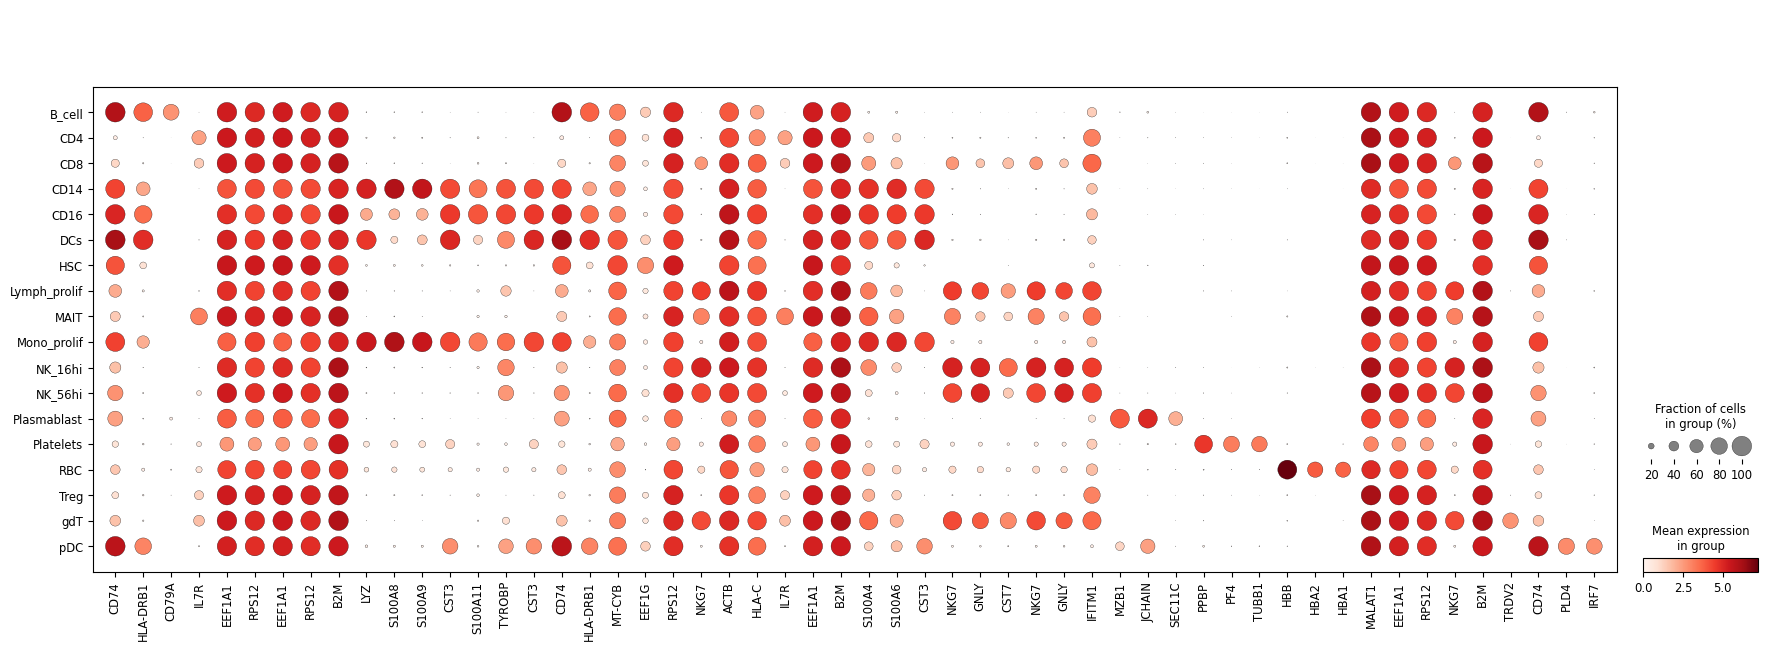

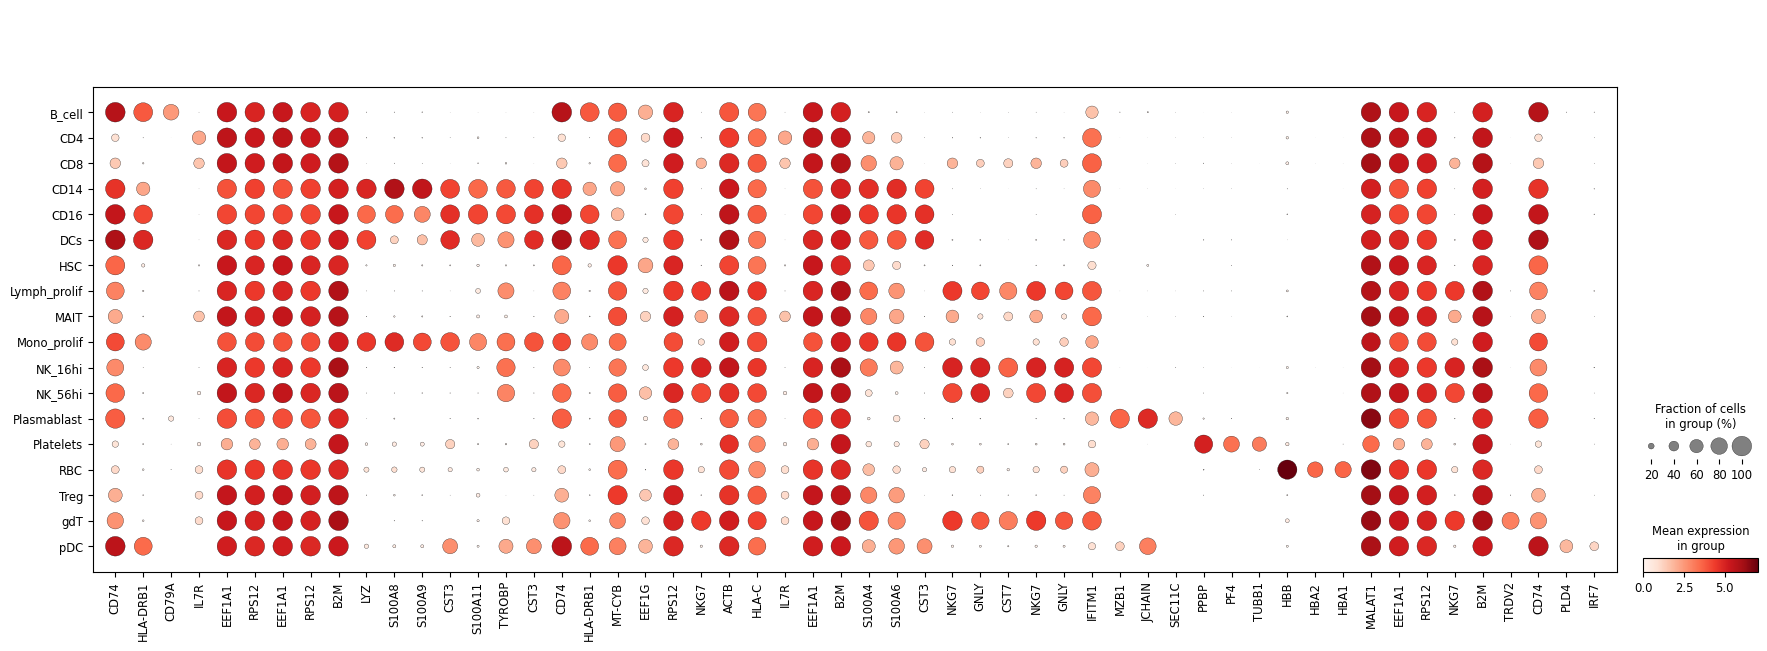

Expression fraction (size) similarity between real and semi-profiled:
PearsonRResult(statistic=0.9819307534597735, pvalue=0.0)
Expression intensity (color) similarity between real and semi-profiled
PearsonRResult(statistic=0.9883370882039674, pvalue=0.0)


In [18]:
celltype_signature_comparison(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes')

### Use RRHO plot to compare markers


In [19]:
# choose any cell type
print(totaltypes)
selected_celltype = 'CD4'

['B_cell' 'CD4' 'CD8' 'CD14' 'CD16' 'DCs' 'HSC' 'Lymph_prolif' 'MAIT'
 'Mono_prolif' 'NK_16hi' 'NK_56hi' 'Plasmablast' 'Platelets' 'RBC' 'Treg'
 'gdT' 'pDC']


In [ ]:
#print(rrho.__doc__)

Plotting RRHO for comparing CD4 markers.


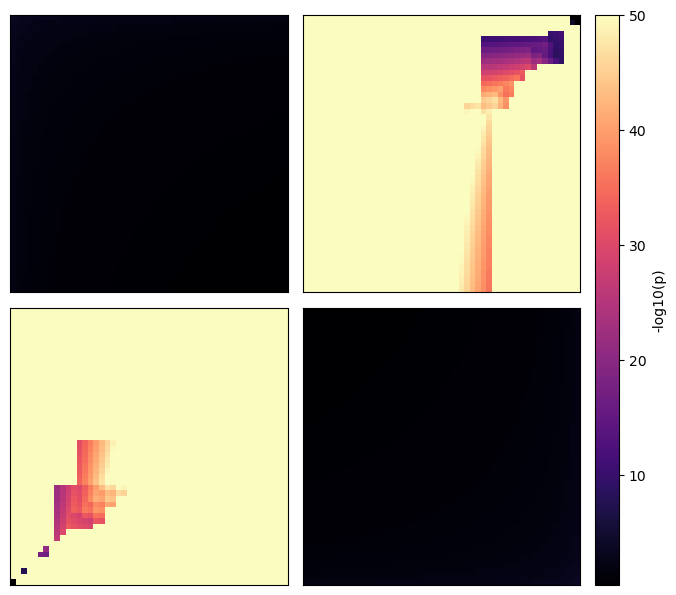

In [20]:
rrho(gtdata=gtdata,semisdata=semisdata,celltype_key='celltypes',celltype=selected_celltype)

### Compare GO enrichment analysis similarity

In [ ]:
#print(enrichment_comparison.__doc__)

p-value of hypergeometric test for overlapping DEGs: 8.123156530740906e-169
Significance correlation: PearsonRResult(statistic=0.9982044964337531, pvalue=8.386702428528312e-15)


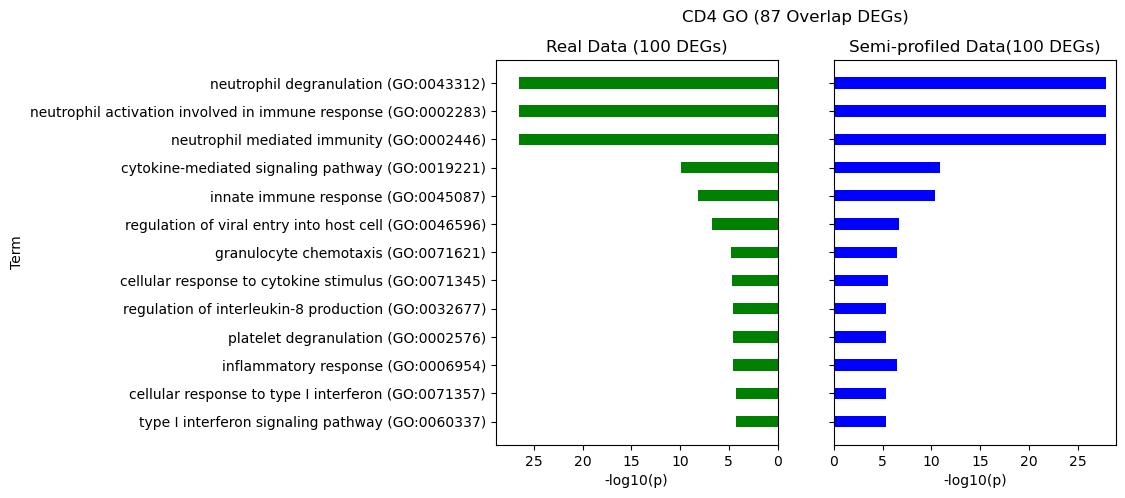

In [21]:
selected_celltype = 'CD4'
enrichment_comparison(name, gtdata, semisdata, celltype_key = 'celltypes', selectedtype = selected_celltype)

### Compare partition-based graph abstraction (PAGA) graph similarity

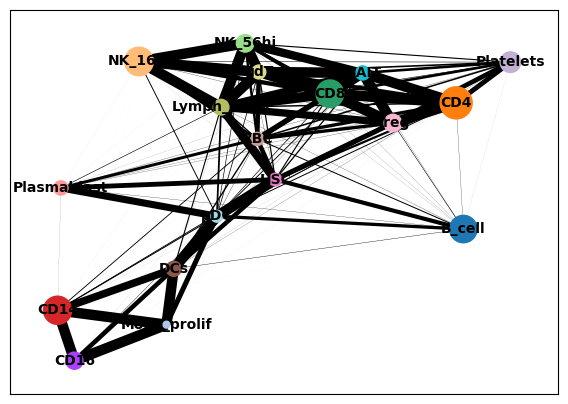

In [22]:
# GROUND TRUTH
threshold = 0
sc.tl.pca(gtdata,n_comps=100)
sc.pp.neighbors(gtdata,use_rep='X_pca',n_neighbors=50)
sc.tl.paga(gtdata, groups = 'celltypes')
sc.pl.paga(gtdata, plot=True,threshold=threshold)

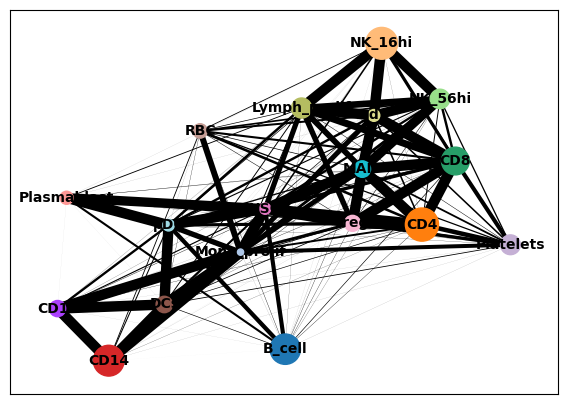

In [23]:
# SEMI-PROFILED
threshold = 0
sc.tl.pca(semisdata,n_comps=100)
sc.pp.neighbors(semisdata,use_rep='X_pca',n_neighbors=50)
sc.tl.paga(semisdata, groups = 'celltypes')
sc.pl.paga(semisdata, plot=True,threshold=threshold)

In [24]:
gtpaga = np.array(gtdata.uns['paga']['connectivities'].todense())
semipaga = np.array(semisdata.uns['paga']['connectivities'].todense())
gtpaga = gtpaga.reshape((-1))
semipaga= semipaga.reshape((-1))
print('Correlation between the two adjacency matrices:')
scipy.stats.pearsonr(gtpaga,semipaga)

Correlation between the two adjacency matrices:


PearsonRResult(statistic=0.852556634036606, pvalue=9.469411890287614e-93)

### Using CellChat to perform cell-cell interaction analysis
If you would like to perform cell-cell interaction analysis using CellChat, we recommend creating another conda environment according to the instructions below: \
Create environment: 
```
conda create -n r_analysis r-essentials r-base
```
Activate it: 
```
conda activate r_analysis
```
Start an interactive R session:
```
R
```
Install necessary packages:

1
```
install.packages('devtools')
```

2
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("Biobase")
```

3 
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("ComplexHeatmap")
```

4
```
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
BiocManager::install("BiocNeighbors")
```

5
```
devtools::install_github("sqjin/CellChat")
```

Then install this R environment as a Jupyter Notebook kernel:

```
install.packages('IRkernel')
IRkernel::installspec(user = TRUE)

```

This finishes configuring the environment needed. You should be able to select the 'R' kernel in Jupyter Notebook. We will export some single-cell data for cell-cell interaction analysis.

### Export single-cell data for analysis
We export real and semi-profiled cells from moderate COVID-19 patients.

In [25]:
condition_real = gtdata[gtdata.obs['states_collection_sum'] == 'Moderate']
condition_semi = semisdata[semidata.obs['states_collection_sum'] == 'Moderate']
condition_real.write(name + '/moderate_real.h5ad')
condition_semi.write(name + '/moderate_semi.h5ad')

Then please open our notebook "cellchat_eg.ipynb" to proceed with the analysis. 

## End of comprehensive semi-profiling performance evaluation
Based on only two representative samples, the semi-profiled 12-sample cohort has very similar downstream analysis results as the real-profiled cohort, which contains heterogeneous samples from 6 different COVID-19 severity levels.

## Optional: New Representative Selection and Run the Next Round
You have the option to employ active learning for the selection of additional representatives. This approach can result in some target samples having more similar representatives, thereby enhancing the accuracy of the inference process.

## Round 2 semi-profiling

### select a new batch of representatives using active learning:

In [26]:
representatives = name + '/status/init_representatives.txt'
cluster = name + '/status/init_cluster_labels.txt'
targetid = None
bulktype = 'pseudobulk'

In [27]:
#print(semi.activeselection.__doc__)

In [28]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


### obtain single-cell data for new representatives:

In [6]:
semi.get_eg_representatives(name)

Obtained single-cell data for representatives.


In [7]:
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed=True,logged=False,cellfilter=False,threshold=1e-3,geneset=True,weight=0.5,k=15)

Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


### run single-cell inference again with more representatives:

In [10]:
representatives = name + '/status/eer_representatives_2.txt'
cluster = name + '/status/eer_cluster_labels_2.txt'
bulktype = 'pseudobulk'

semi.scinfer(name, representatives,cluster,bulktype)

Start single-cell inference in cohort mode
pretrain 1: representative reconstruction
load existing pretrain 1 reconstruction model for BGCV09_CV0279
load existing pretrain 1 reconstruction model for MH9143426
load existing pretrain 1 reconstruction model for BGCV07_CV0137
load existing pretrain 1 reconstruction model for MH8919226
pretrain2: reconstruction with representative bulk loss
load existing model
load existing pretrain 2 model for BGCV09_CV0279
load existing model
load existing pretrain 2 model for MH9143426
load existing model
load existing pretrain 2 model for BGCV07_CV0137
load existing model
load existing pretrain 2 model for MH8919226
inference
Inference for AP8 has been finished previously. Skip.
Inference for BGCV02_CV0068 has been finished previously. Skip.
Inference for BGCV03_CV0084 has been finished previously. Skip.
Inference for BGCV03_CV0176 has been finished previously. Skip.
Inference for BGCV04_CV0164 has been finished previously. Skip.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:23<00:00,  6.33it/s, v_num=1, train_loss_step=61


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:23<00:00,  6.33it/s, v_num=1, train_loss_step=61


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:24<00:00,  6.24it/s, v_num=1, train_loss_step=61


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:29<00:00,  5.16it/s, v_num=1, train_loss_step=63


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 150/150: 100%|█| 150/150 [00:29<00:00,  5.15it/s, v_num=1, train_loss_step=62
Inference for MH9143322 has been finished previously. Skip.
Inference for newcastle20 has been finished previously. Skip.
Finished single-cell inference


## stop criteria
In real world application, you do not have the ground truth data for evaluating semi-profiling performance. But you can decide if you want to stop or continue semi-profiling with more representatives based on your budget, or evaluating the semi-profiling performance by comparing the representatives and their inferred data in the previous round.

In [11]:
## GET REAL AND INFERRED NEW REPRESENTATIVES:

#print(assemble_representatives.__doc__)
real_rep, inferred_rep = assemble_representatives(name,celltype_key='celltypes',sample_info_keys = ['states_collection_sum'],rnd=2,batch=2)




    Assemble previous round of inferred representative data and annotate the cell type. The real-profiled representatives in the current round is also provided for comparison.
    
    Parameters
    ----------
    name: 
        Project name
    celltype_key:
        The key in .obs specifying the cell type information
    sample_info_keys:
        Keys for other sample-level information to be stored in the assembled dataset
    rnd:
        The round of semi-profiling to assemble. For example, select the second round (2 batches of representatives) using rnd = 2
    batch:
        The representative selection batch size

    Returns
    -------
    realrepdata:
        The real-profiled representative dataset
    infrepdata:
        The inferred representative dataset

    Example
    -------
    >>> real_rep, inferred_rep = assemble_representatives(name,celltype_key='celltypes',sample_info_keys = ['states_collection_sum'],rnd=2,batch=2)


    
Training cell type annotator.
Finished.

then you can compare them using any of the anlaysis tasks shown previously, e.g UMAP, deconvolution.


    Compare the real-profiled and semi-profiled datasets by plotting them in a same UMAP
    
    Parameters
    ----------
    semidata:
        Semi-profiled dataset
    gtdata:
        Real-profiled dataset
    name: 
        Project name
    celltype_key:
        The key in .obs specifying the cell type information

    Returns
    -------
    combdata
        Combined dataset, with real-profiled cells in the front
    gtdata
        Real-profiled dataset
    semidata
        Semi-profiled dataset
        
    Example
    -------
    >>> combdata, gtdata, semidata = compare_adata_umaps(
    >>> inferred_rep, # inferred representatives from the last round
    >>> real_rep,     # real-profiled representatives from the current round          
    >>> name = name,  # project name
    >>> celltype_key = 'celltypes'
    >>> )
        
    


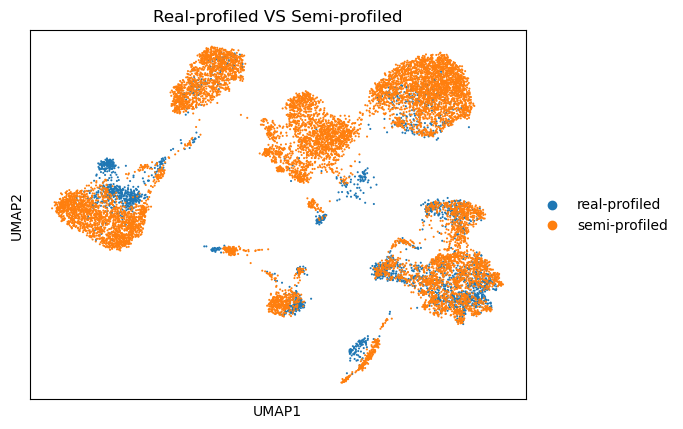

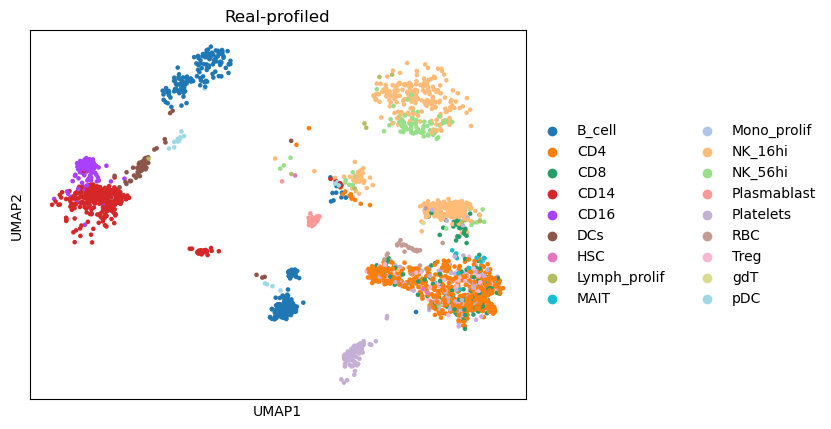

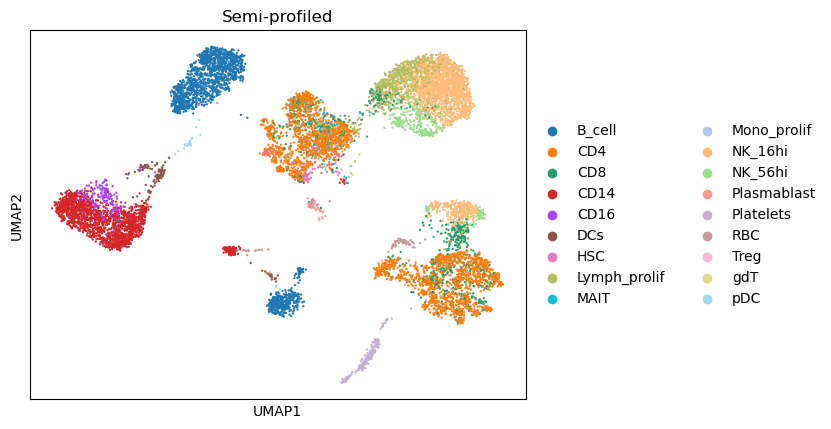

In [12]:
#print(compare_adata_umaps.__doc__)
_ = compare_adata_umaps(
    inferred_rep,
    real_rep,                
    name = name,
    celltype_key = 'celltypes'
    )


In [13]:
totaltypes = np.array(inferred_rep.obs['celltypes'].cat.categories)
real_prop = celltype_proportion(real_rep,totaltypes)
inferred_prop = celltype_proportion(inferred_rep,totaltypes)
print('Pearson Correlation between the two versions of cell type proportions:')
print(scipy.stats.pearsonr(real_prop,inferred_prop))

Pearson Correlation between the two versions of cell type proportions:
PearsonRResult(statistic=0.941594207428553, pvalue=5.663838653869166e-09)


This Pearson Correlation 0.94 between real and estimated cell type proportion is generally considered as good deconvolution performance. So if your are mainly focusing on cell type-level analysis then you can stop here. If you are not satisfied with it or not satisfied with more in-depth analysis results, you can select more representatives and go to the next round.

## new representative selection using active learning

In [14]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Round 3 semi-profiling

In [16]:
semi.get_eg_representatives(name)
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed=True,logged=False,cellfilter=False,threshold=1e-3,geneset=True,weight=0.5,k=15)

Obtained single-cell data for representatives.
Processing representative single-cell data
Removing background noise
Computing geneset scores
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 4240
Augmenting and saving single-cell data.
Finished processing representative single-cell data


In [ ]:
representatives = name + '/status/eer_representatives_3.txt'
cluster = name + '/status/eer_cluster_labels_3.txt'
semi.scinfer(name, representatives,cluster,bulktype)

In [7]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Round 4 semi-profiling

In [ ]:
semi.get_eg_representatives(name)
semi.scprocess(name=name,singlecell=name+'/representative_sc.h5ad',normed=True,logged=False,cellfilter=False,threshold=1e-3,geneset=True,weight=0.5,k=15)
representatives = name + '/status/eer_representatives_4.txt'
cluster = name + '/status/eer_cluster_labels_4.txt'
semi.scinfer(name, representatives,cluster,bulktype)

In [9]:
semi.activeselection(name, representatives,cluster,batch=2,lambdasc=1,lambdapb=1)

Running active learning to select new representatives
selection finished


## Error curve
After performing several rounds of semi-profiling, we can visualize how error and cost changes according to number of representatives selected.


### compute errors of each round

In [10]:
#print(get_error.__doc__)

In [11]:

upperbounds, lowerbounds, semierrors, naiveerrors = get_error(name)


loading and processing ground truth data.
finished processing ground truth 1.2295792470686138  seconds
computing error for each round
round  1
loading semi-profiled cohort
1.1840079119428992 for loading semi-profiled cohort.
pca
26.758460994809866 for pca
computing errors
26.88654889492318 for computing error.
round  2
loading semi-profiled cohort
0.9010690688155591 for loading semi-profiled cohort.
pca
16.620059818960726 for pca
computing errors
20.35655738785863 for computing error.
round  3
loading semi-profiled cohort
0.5831471662968397 for loading semi-profiled cohort.
pca
16.588291167281568 for pca
computing errors
17.862583199050277 for computing error.
round  4
loading semi-profiled cohort
0.4018680630251765 for loading semi-profiled cohort.
pca
13.589082167018205 for pca
computing errors
15.554514691233635 for computing error.
round  5
loading semi-profiled cohort
0.26858254382386804 for loading semi-profiled cohort.
pca
14.051444616168737 for pca
computing errors
15.601672375

### visualize the errors

In [12]:
#print(errorcurve.__doc__)

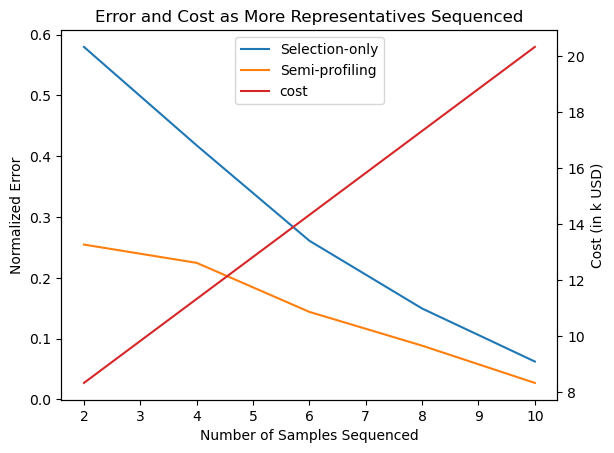

In [13]:

errorcurve(upperbounds, lowerbounds, semierrors, naiveerrors, batch=2,total_samples = 12)

